# ⚠️ Configuration Required

Before running this notebook, you need to:

1. **Get your NCBI API Key**:
   - Register at: https://www.ncbi.nlm.nih.gov/account/
   - Generate API key in your account settings

2. **Set your API key** in the configuration cell below

3. **Configure email** (required by NCBI)

---


# PubMed Literature Retrieval and Interactive Reading List Generator

**Authors:** 李想 (Li Xiang) & GitHub Copilot  
**Date:** 2025-12-22  
**Version:** 2.0  
**License:** MIT

## Purpose

This notebook provides an automated workflow for:
1. Querying PubMed database with advanced search syntax
2. Extracting article metadata (Title, Journal, Abstract, DOI, etc.)
3. Enriching data with journal Impact Factors from ScienceDirect
4. Generating an interactive HTML reading list with:
   - Night mode optimized design
   - Keyword highlighting
   - Collapsible sidebar bookmarks with status indicators
   - Star and read marking functionality
   - Persistent state across sessions

## Features

- **Advanced Search**: Supports PubMed query syntax with field tags, boolean operators, and wildcards
- **Impact Factor Integration**: Automatically scrapes IF and Quartile information
- **Interactive HTML**: Star important papers, mark as read, with sidebar navigation
- **Status Synchronization**: Sidebar bookmarks show real-time star ⭐ and read ✓ indicators
- **Responsive Design**: Collapsible sidebar with smooth transitions

## Requirements

```
biopython
pandas
openpyxl
requests
beautifulsoup4
tqdm
```

## Workflow

1. **Import modules** → 2. **Configure search parameters** → 3. **Query PubMed** → 4. **Enrich with IF** → 5. **Generate HTML**

---

In [5]:
import importlib
import sys
from pubmed_utils import *

## 1. Configure Search Parameters

Set up your PubMed query with the following parameters:

### Key Parameters:

- **`api_key`**: NCBI E-utilities API key (get free key from https://www.ncbi.nlm.nih.gov/account/)
  - Increases rate limit from 3 to 10 requests/second

- **`search_key_words`**: PubMed advanced search query
  - Supports: `AND`, `OR`, `NOT` operators
  - Field tags: `[Title]`, `[Title/Abstract]`, `[Author]`, `[Journal]`, `[MeSH Terms]`, `[Affiliation]`
  - Wildcards: `fibro*` matches "fibroblast", "fibrosis", etc.
  - Example: `(wnt5a NOT cancer) AND fibro*`

- **`release_date_cutoff`**: Only fetch papers from last N days (None = all time)

- **`paper_type`**: Filter by article type
  - Options: `"Journal Article"`, `"Review"`, `"Case Reports"`, `"Clinical Trial"`, etc.

- **`grab_total`**: Limit number of papers to fetch
  - `None`: Get all results (recommended for <1000 papers)
  - Integer: Limit to first N papers

- **`save_path`**: Excel output file path

In [6]:
api_key = "YOUR_NCBI_API_KEY_HERE"                        # NCBI eUtils API key

# 搜索关键词（支持逻辑符号和PubMed高级搜索语法）
search_key_words = "(wnt AND yap AND fibro*) NOT (Review)"

# ===== 搜索示例 =====
# 基础搜索：
# search_key_words = "wnt5a"                                         # 单个关键词

# 逻辑运算符：
# search_key_words = "wnt5a AND cancer"                              # AND逻辑（同时包含）
# search_key_words = "wnt5a OR wnt7a"                                # OR逻辑（包含任一）
# search_key_words = "wnt5a NOT cancer"                              # NOT逻辑（排除）
# search_key_words = "(wnt5a OR wnt7a) AND cancer"                   # 组合逻辑

# 字段限定搜索：
# search_key_words = "wnt5a[Title]"                                  # 仅在标题中搜索
# search_key_words = "wnt5a[Title/Abstract]"                         # 在标题或摘要中搜索
# search_key_words = "Smith J[Author]"                               # 按作者搜索
# search_key_words = "Nature[Journal]"                               # 按期刊搜索

# 高级组合：
# search_key_words = "wnt5a[Title/Abstract] AND cancer[MeSH Terms]"  # 标题/摘要含wnt5a且MeSH词为cancer
# search_key_words = "breast cancer AND China[Affiliation]"          # 中国机构的乳腺癌研究
# ==================

release_date_cutoff = 365*5                                      # 发布时间范围（天数），None表示所有
paper_type = "Journal Article"                                         # 论文类型：Journal Article, Review, Case Reports, Clinical Trial...
save_path = "./paper_donload/wnt_fibro_yap.xlsx"                        # Excel保存路径

# grab_total 参数说明：
# - None: 获取所有搜索结果（推荐用于小规模搜索，<1000篇）
#         例如：grab_total = None  # 如果搜索到500篇，就获取全部500篇
# - 指定数字: 限制获取的论文数量（推荐用于大规模搜索）
#         例如：grab_total = 100   # 只获取前100篇（即使搜索到5000篇）
#         例如：grab_total = 50    # 只获取前50篇
# 影响：
#   1. 控制Excel中的数据行数
#   2. 影响程序运行时间（每10篇约需1-2秒）
#   3. 如果设置值 > 实际搜索结果数，会自动调整为实际数量
grab_total = None                                                   # 获取论文数量

pdf_savepath = "./paper_donload/"                                    # PDF保存路径
IF_cutoff = 0                                                        # 下载IF高于此值的论文

## 2. Query PubMed and Extract Metadata

This step:
1. Searches PubMed with your query via NCBI E-utilities API
2. Fetches article details in batches (10 articles per request)
3. Extracts metadata:
   - PMID (unique identifier)
   - Title
   - Journal name
   - Publication date
   - Abstract
   - DOI
4. Saves to Excel with 11 columns (IF/Quartile columns added in next step)

**Progress bar** shows real-time fetching status.

**Note:** If you already have the Excel file and only want to regenerate HTML, comment out this cell to skip re-querying PubMed.

In [ ]:
from pubmed_utils import pubmed_utils
my_pubmed_utils = pubmed_utils()
my_pubmed_utils.get_main_info_into_excel(api_key, search_key_words, release_date_cutoff, paper_type, grab_total, save_path)
print("main info has been writen to excel!")

## 3. Enrich with Impact Factor Information

This step:
1. Reads journal names from the Excel file
2. Scrapes ScienceDirect for:
   - **Impact Factor (IF)**
   - **JCR Quartile** (Q1/Q2/Q3/Q4)
   - **CSA Quartile**
   - **Open Access status**
3. Uses fuzzy matching for journal name variations
4. Updates Excel with IF information

**Note:** This step can be run independently on existing Excel files using `embed_IF_into_excel(path)`.

**Common Issues:**
- Empty IF column → Journal name mismatch (use `refine_IF_matching()` for manual correction)
- ScienceDirect may have different journal abbreviations

In [ ]:
# from pubmed_utils import pubmed_utils
# my_pubmed_utils = pubmed_utils()
my_pubmed_utils.embed_IF_into_excel(save_path)
print("IF info has been writen to excel!")
# my_pubmed_utils.download_pdf(save_path, pdf_savepath, IF_cutoff)

## 4. Generate Interactive HTML Reading List

This step generates a styled HTML file with:

### Visual Features:
- **Night Mode Design**: Dark gradient background optimized for reading
- **Keyword Highlighting**: Search terms highlighted in yellow (title) and orange (abstract)
- **Colored Metadata**: IF, Quartile, Journal, Date displayed with color coding

### Interactive Features:
1. **Collapsible Sidebar (☰ button)**:
   - Bookmarks list: `Journal. YYYYMMDD` format
   - Status indicators: ⭐ (starred), ✓ (read)
   - Click bookmark to jump to article
   - Toggle button to show/hide sidebar

2. **Article Cards**:
   - ⭐ Star button: Mark important papers
   - ✓ Read button: Mark as read
   - Starred articles show gold left border
   - Read articles reduce opacity to 0.6

3. **State Persistence**:
   - All star/read states saved in browser localStorage
   - Sidebar indicators update in real-time
   - States preserved across page reloads

### Output:
- HTML file saved to: `./paper_donload/{query_name}_reading_list.html`
- Open in any modern web browser

**Tip:** Use `importlib.reload(html_generate)` before calling `generate_reading_list()` if you modified `html_generate.py`.

In [ ]:
import os 
import importlib
import html_generate
importlib.reload(html_generate)
from html_generate import generate_reading_list

# in case you want to regenerate from previous query# you can set excel_path mannualy, for example# excel_path = 'path/to/your/excel'
excel_path = save_path
out_dir = os.path.dirname(excel_path) or '.'
os.makedirs(out_dir, exist_ok=True)
output_html = os.path.join(out_dir, os.path.splitext(os.path.basename(excel_path))[0] + '_reading_list.html')

search_info = {
    'search_keywords': search_key_words,
    'paper_type': paper_type,
    'release_date_cutoff': release_date_cutoff,
    'grab_total': grab_total,
    'save_path': save_path,
    'search_date': None
}

generate_reading_list(excel_path, output_html, search_info=search_info)
print(f'HTML已生成: {output_html}')

# The HTML generated may look like this:
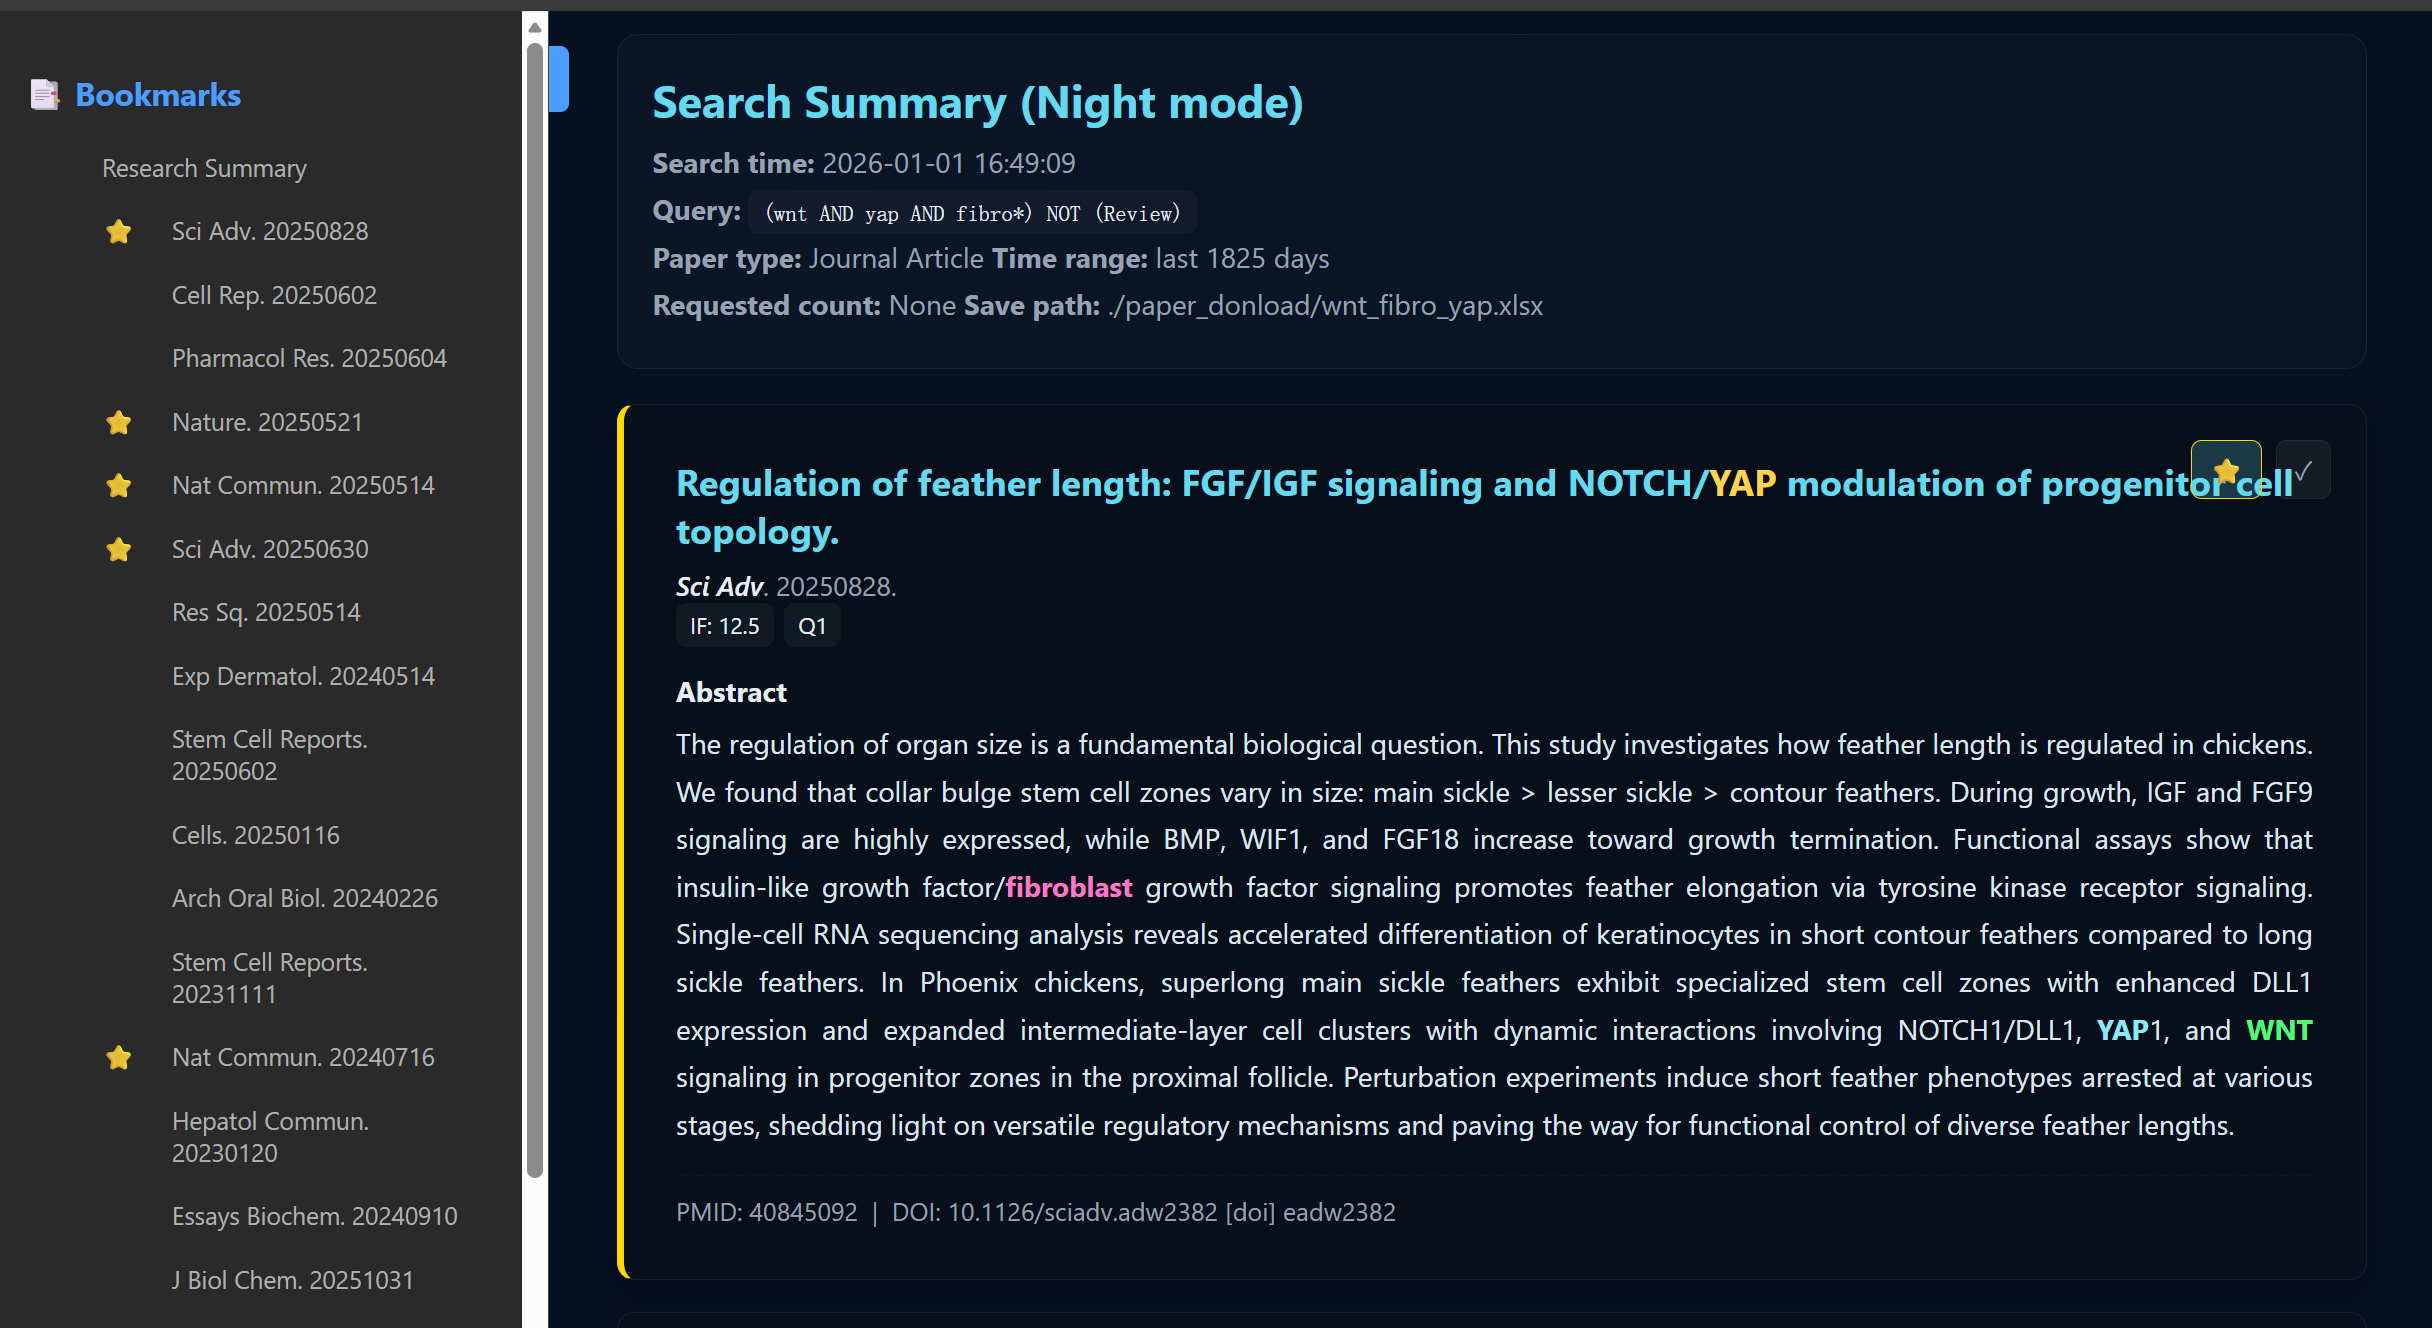

---

## Additional Features

### PDF Download (Optional)

Uncomment the last line in the IF enrichment cell to enable automatic PDF download:

```python
my_pubmed_utils.download_pdf(save_path, pdf_savepath, IF_cutoff)
```

Downloads PDFs for papers with IF > `IF_cutoff` to `pdf_savepath` directory.

### Independent IF Update

Update IF information for existing Excel files without re-querying PubMed:

```python
my_pubmed_utils.embed_IF_into_excel('path/to/existing.xlsx')
```

### Troubleshooting

**Problem:** NCBI API rate limit exceeded  
**Solution:** Get free API key from https://www.ncbi.nlm.nih.gov/account/

**Problem:** Empty IF column in Excel  
**Solution:** Journal name mismatch - use `refine_IF_matching()` for manual correction

**Problem:** HTML buttons not working  
**Solution:** Check browser console for JavaScript errors, ensure modern browser (Chrome/Firefox/Edge)

**Problem:** Sidebar not showing bookmarks  
**Solution:** Ensure Excel has `Journal` and `publish_date` columns populated

## Project Structure

```
grab-pubmed-info-master/
├── pumbed_query.ipynb          # Main workflow notebook
├── pubmed_utils.py             # PubMed API interaction & IF scraping
├── html_generate.py            # HTML generation with interactive features
├── paper_donload/              # Output directory
│   ├── *.xlsx                  # Excel files with metadata
│   └── *_reading_list.html     # Generated HTML reading lists
└── README.md                   # Project documentation
```

## Contributing

Contributions are welcome! Please feel free to submit pull requests or open issues.

## License

MIT License - see LICENSE file for details.

---

*Generated with ❤️ by PubMed Info Grabber*